# Adaptive Instance Normalization

### Implementing StyleGAN - Part 1

In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K

Using TensorFlow backend.


In [6]:
# download pokemon.npy
!gdown https://drive.google.com/uc?id=1cmu3uuBH91E_laIC7wnCellfJv5cSa0O
# !mkdir -p data
# !mv pokemon.npy data

Downloading...
From: https://drive.google.com/uc?id=1cmu3uuBH91E_laIC7wnCellfJv5cSa0O
To: /content/pokemon.npy
129MB [00:01, 110MB/s] 


10466 images.


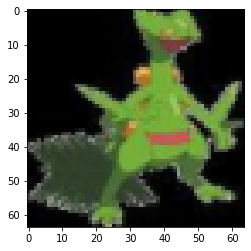

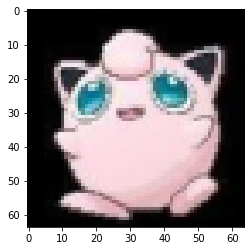

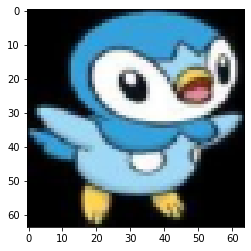

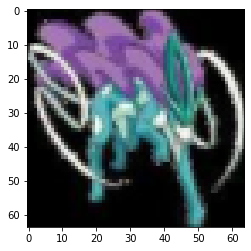

In [7]:
#Hyperparameters and statistics
batch_size = 64
iterations = 50000

d_loss = []
g_loss = []
gp_loss = []

#Import data
x_train = np.load('pokemon.npy')

#Normalize data
x_train = x_train.astype('float32') / 255.0

#Check number of images
print(str(x_train.shape[0]) + " images.")


image_indices = np.random.randint(0, x_train.shape[0] - 1, [4])
real_images = x_train[image_indices]

for i in range(4):
    plt.figure(i)
    plt.imshow(real_images[i])

plt.show()

In [0]:
def r1_gradient_penalty(y_true, y_pred, samples):
    #Get gradients of pixel values (first layer)
    gradients = K.gradients(y_pred, samples)[0]
    
    #Get norm squared: ||grad||^2
    gradients_sqr = K.square(gradients)
    gradient_norm = K.sum(gradients_sqr, axis = [1, 2, 3])
    
    #Return average over batch
    return K.mean(gradient_norm)

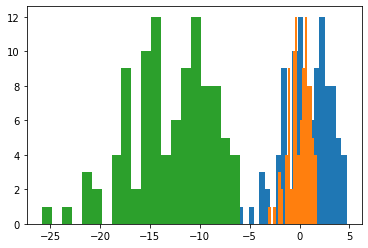

In [9]:
#For illustration purpose only!
scale = 4.1
bias = -13

#Random data
data = np.random.normal(0.7, 2.3, [100])

#Normalize data
normalized_data = (data - np.mean(data)) / np.std(data)

#Scale and Bias data
new_data = (normalized_data * scale) + bias

#Plot data
#plt.figure(1)
plt.hist(data, bins = 20)

#plt.figure(2)
plt.hist(normalized_data, bins = 20)

#plt.figure(3)
plt.hist(new_data, bins = 20)

plt.show()

![PikaChannels.png](attachment:PikaChannels.png)

In [0]:
def AdaIN(x):
    #Normalize x[0] (image representation)
    mean = K.mean(x[0], axis = [1, 2], keepdims = True)
    std = K.std(x[0], axis = [1, 2], keepdims = True) + 1e-7
    y = (x[0] - mean) / std
    
    #Reshape scale and bias parameters
    pool_shape = [-1, 1, 1, y.shape[-1]]
    scale = K.reshape(x[1], pool_shape)
    bias = K.reshape(x[2], pool_shape)
    
    #Multiply by x[1] (GAMMA) and add x[2] (BETA)
    return y * scale + bias

In [0]:
def g_block(input_tensor, latent_vector, filters):
    gamma = Dense(filters, bias_initializer = 'ones')(latent_vector)
    beta = Dense(filters)(latent_vector)
    
    out = UpSampling2D()(input_tensor)
    out = Conv2D(filters, 3, padding = 'same')(out)
    out = Lambda(AdaIN)([out, gamma, beta])
    out = Activation('relu')(out)
    
    return out

In [0]:
def d_block(input_tensor, filters):
    out = Conv2D(filters, 3, padding = 'same')(input_tensor)
    out = LeakyReLU(0.2)(out)
    out = AveragePooling2D()(out)
    return out

In [13]:
#Latent input
latent_input = Input([64])

#Map latent input
latent = Dense(64, activation = 'relu')(latent_input)
latent = Dense(64, activation = 'relu')(latent)
latent = Dense(64, activation = 'relu')(latent)

#Reshape to 4x4x64
x = Dense(4*4*64, activation = 'relu')(latent_input)
x = Reshape([4, 4, 64])(x)

#Size: 4x4x64
x = g_block(x, latent, 64)

#Size: 8x8x64
x = g_block(x, latent, 32)

#Size: 16x16x32
x = g_block(x, latent, 16)

#Size: 32x32x16
x = g_block(x, latent, 8)

#Size: 64x64x8, make RGB with values between 0 and 1
image_output = Conv2D(3, 1, padding = 'same', activation = 'sigmoid')(x)

#Make Model
generator = Model(inputs = latent_input, outputs = image_output)

#Model Summary
generator.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1024)         66560       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4, 4, 64)     0           dense_4[0][0]                    
________________________________________________________________________________________

In [14]:
#Image input
image_input = Input([64, 64, 3])

#Size: 64x64x3
x = d_block(image_input, 8)

#Size: 32x32x8
x = d_block(x, 16)

#Size: 16x16x16
x = d_block(x, 32)

#Size: 8x8x32
x = d_block(x, 64)

#Size: 4x4x64
x = Conv2D(128, 3, padding = 'same')(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)

#1-dimensional Neural Network
class_output = Dense(1)(x)

#Make Model
discriminator = Model(inputs = image_input, outputs = class_output)

#Model summary
discriminator.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 8)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 16)        0  

![Youtube%20Figures%20%281%29.png](attachment:Youtube%20Figures%20%281%29.png)

In [15]:
#Build network to train the discriminator.
#Discriminator will train, but Generator won't train.
for layer in discriminator.layers:
    layer.trainable = True
    
for layer in generator.layers:
    layer.trainable = False
    
    
    
#Get real image
real_image = Input([64, 64, 3])

#Discriminator classifies
validity_real = discriminator(real_image)



#Get latent input
latent_input = Input([64])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity_fake = discriminator(fake_image)


#Create Gradient Penalty Loss with Real Samples
partial_gp = partial(r1_gradient_penalty, samples = real_image)

#Create and compile the model
DiscriminatorModel = Model(inputs = [real_image, latent_input], outputs = [validity_real, validity_fake, validity_real])

DiscriminatorModel.compile(optimizer = RMSprop(lr = 0.0002),
                           loss = ['mean_squared_error', 'mean_squared_error', partial_gp],
                           loss_weights = [1, 1, 10])

![Youtube%20Figures%20%282%29.png](attachment:Youtube%20Figures%20%282%29.png)

In [0]:
#Build network to train the generator.
#Discriminator won't train, but Generator will train.
for layer in discriminator.layers:
    layer.trainable = False
    
for layer in generator.layers:
    layer.trainable = True

#Get latent input
latent_input = Input([64])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity = discriminator(fake_image)

#Create and compile the model
GeneratorModel = Model(inputs = latent_input, outputs = validity)

GeneratorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = 'mean_squared_error')

In [17]:
#Train the models in a loop
for i in range(iterations):
    
    print('\rIteration ' + str(i), end = '')
    
    #Get labels
    real_labels = np.ones([batch_size, 1])
    fake_labels = np.zeros([batch_size, 1])
    dummy_labels = np.ones([batch_size, 1])
    
    #Train discriminator
    #Get images and latent vectors
    image_indices = np.random.randint(0, x_train.shape[0] - 1, [batch_size])
    real_images = x_train[image_indices]
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 64])
    
    #Train
    loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors], [real_labels, fake_labels, dummy_labels])
    d_loss.append(loss[1]/2 + loss[2]/2)
    gp_loss.append(loss[3])
    
    #Train generator
    #Get latent vectors
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 64])
    
    #Train using opposite labels
    loss = GeneratorModel.train_on_batch(latent_vectors, real_labels)
    g_loss.append(loss)

Iteration 0

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'










Iteration 1

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iteration 297

KeyboardInterrupt: ignored

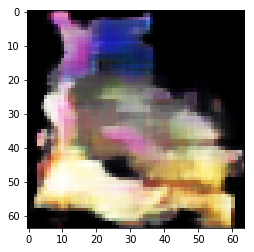

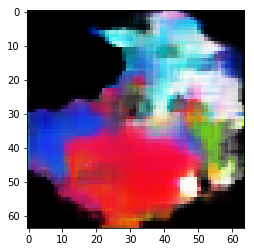

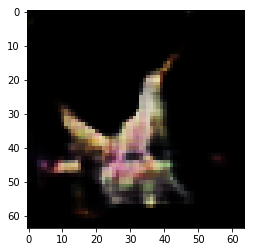

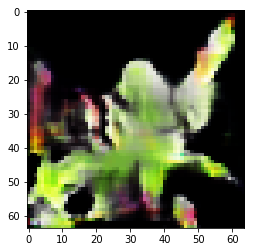

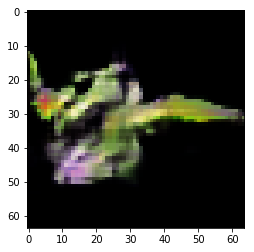

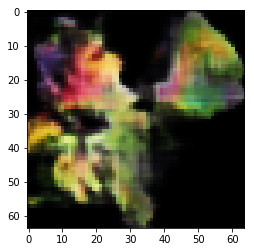

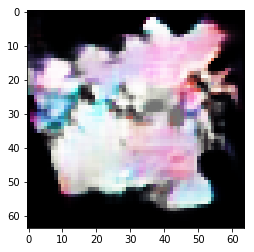

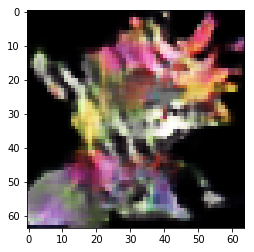

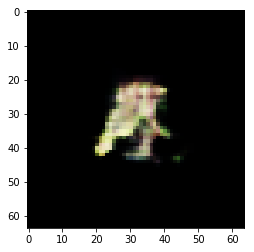

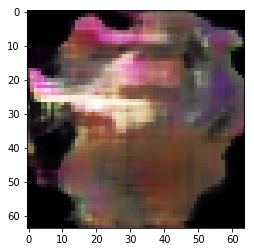

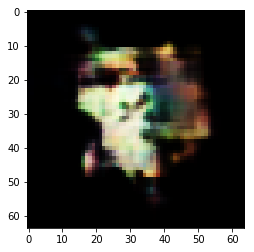

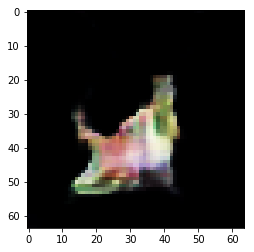

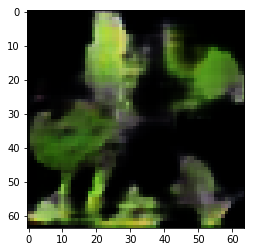

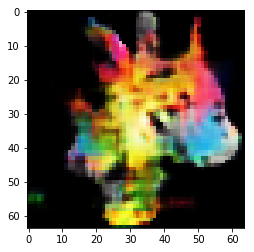

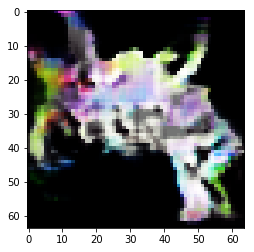

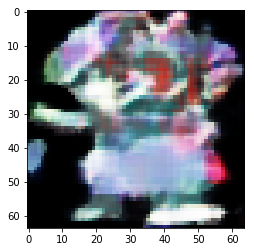

In [0]:
#Show samples
latent_vectors = np.random.normal(0.0, 1.0, [16, 64])
fake_images = generator.predict(latent_vectors)

for i in range(16):
    plt.figure(i)
    plt.imshow(fake_images[i])

plt.show()

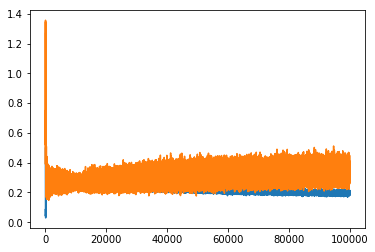

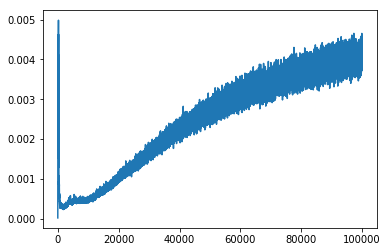

In [0]:
#Plot losses
plt.plot(d_loss)
plt.plot(g_loss)
plt.show()

plt.plot(gp_loss)
plt.show()

In [0]:
from PIL import Image
latent_vectors = np.random.normal(0.0, 1.0, [2000, 64])
fake_images = generator.predict(latent_vectors)

cols = []

for i in range(200):
    cols.append(np.concatenate(fake_images[i*10:i*10+10], axis = 0))

grid = np.concatenate(cols, axis = 1)
x = Image.fromarray(np.uint8(grid*255))
x.save("Results/grid.png")